# Reading and Preparing Data

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, accuracy_score, make_scorer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_validate
from joblib import dump, load
from tensorflow.keras.metrics import BinaryAccuracy, AUC
import matplotlib.pyplot as plt
from scipy import sparse

import glob
import gc

In [2]:
# reading in FASTA files containing the Amino Acid sequences
def read_fasta(file_names):
    """
    Reads a FASTA files and returns a pd DataFrame with the protein names and Amino Acid sequences
    # Params
    file_names: list of fasta file names to read
    
    # Returns
    df: the DataFrame containing the names and sequences from all inputted files
    """
    df = pd.DataFrame()
    names = []
    sequences = []
    ids = []
    db_id = []
    for file_name in file_names:
        seq = ""
        with open(file_name, "r") as f:
            for line in f:
                # if its reading a comment line extract the name of the target
                if line[0] == '>':
                    sequences.append(seq)
                    seq = ""
                    names.append(' '.join(str(v) for v in line.split(' (D')[0].split()[2:]).lower())
                    ids.append(line.split()[1])
                # if its not on a comment line extract the sequence
                else:
                    seq += line
            # adding the last sequence
            sequences.append(seq)
            # removing empty strings added to list
            sequences.remove("")
    df['Name'] = names
    df['uniprot id'] = ids
    df['sequence'] = sequences
    return df

In [4]:
adj = pd.read_csv('drug_target_data/protein_adjacency_matrix.csv')

In [31]:
# reading the fasta files with the target amino acid sequences
l = [filename for filename in glob.glob('drug_target_data/target_structures/*.fasta')]
seq_df = read_fasta(l)
seq_df.drop_duplicates(inplace=True)
seq_df.sequence = seq_df.sequence.apply(lambda s: s.replace('\n', ''))

seq_df.rename(columns={'uniprot id':"UniProt ID"}, inplace=True)
# removing proteins that are not in the adj dataframe; these are proteins that we don't have domain data for
seq_df = seq_df.loc[seq_df['UniProt ID'].isin(adj['UniProt ID'])]
# removing duplicates
seq_df.drop_duplicates(inplace=True)

seq_df.head()

,Name,UniProt ID,sequence
0,coagulation factor viii,P00451,MQIELSTCFFLCLLRFCFSATRRYYLGAVELSWDYMQSDLGELPVD...
1,coagulation factor v,P12259,MFPGCPRLWVLVVLGTSWVGWGSQGTEAAQLRQFYVAAQGISWSYR...
2,hemoglobin subunit alpha,P69905,MVLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPH...
3,corticosteroid-binding globulin,P08185,MPLLLYTCLLWLPTSGLWTVQAMDPNAAYVNMSNHHRGLASANVDF...
4,sodium/potassium-transporting atpase subunit g...,P54710,MTGLSMDGGGSPKGDVDPFYYDYETVRNGGLIFAGLAFIVGLLILL...


In [30]:
seq_df.loc[seq_df['uniprot id'] == 'P39593']

,Name,uniprot id,sequence


In [7]:
# reading back train dataset
train_dataset = pd.read_csv("drug_target_data/datasets/train_dataset.csv")
test_dataset = pd.read_csv("drug_target_data/datasets/test_dataset.csv")

In [8]:
train_labels = train_dataset.pop('label')
test_labels = test_dataset.pop('label')

In [9]:
gc.collect()

38

In [10]:
train_drugs = train_dataset.drop(columns=['Drug ID', 'UniProt ID', 'SMILES'])
test_drugs = test_dataset.drop(columns=['Drug ID', 'UniProt ID', 'SMILES'])

In [11]:
# using a left merge to preserve the order of the elements in the left DataFrame
train_prot = train_dataset[['UniProt ID']].merge(seq_df, on=['UniProt ID'], how='left')[['sequence', 'UniProt ID']].merge(adj, on=['UniProt ID'], how='left')
test_prot = test_dataset[['UniProt ID']].merge(seq_df, on=['UniProt ID'], how='left')[['sequence', 'UniProt ID']].merge(adj, on=['UniProt ID'], how='left')

train_prot.drop(columns=['UniProt ID'], inplace=True)
test_prot.drop(columns=['UniProt ID'], inplace=True)

In [33]:
train_dataset[['UniProt ID']].merge(seq_df, on=['UniProt ID'], how='left')[['sequence', 'UniProt ID']]

,sequence,UniProt ID
0,NaN,P39593
1,NaN,P13647
2,NaN,Q15274
3,NaN,Q9P286
4,NaN,P9WIE5
...,...,...
23288,NaN,Q8NEY4
23289,NaN,Q9KEI9
23290,NaN,P19624
23291,MLSRAVCGTSRQLAPALGYLGSRQKHSLPDLPYDYGALEPHINAQI...,P04179


# Lasso Model

In [119]:
def find_optimal_lasso(data, labels, num_iter, drug=True):
    ba = BinaryAccuracy()
    test_aucs = []
    test_accs = []
    kf = StratifiedKFold(n_splits=5, shuffle=True)
    scaler = StandardScaler(with_std=False)
    var = VarianceThreshold(0.01)
    # iterating through different value of alpha to see which gives best results
    for a in range(num_iter):
        alpha = 10**(-1*a)
        print(f"Testing Alpha = {alpha}")
        aucs = []
        accs = []
        # using cross validation for metrics
        for i, (train_index, test_index) in enumerate(kf.split(data, labels)):
            print("\tFOLD:", i+1)
            train_feat = data.iloc[train_index, :]
            test_feat = data.iloc[test_index, :]
            train_labels = labels.iloc[train_index]
            test_labels = labels.iloc[test_index]
            # processing data
            if drug:  
                train_feat = scaler.fit_transform(train_feat)
                test_feat = scaler.transform(test_feat)
                train_feat = var.fit_transform(train_feat)
                test_feat = var.transform(test_feat)
            else:
                # protein sequence vectorization
                acc_vect = CountVectorizer(analyzer='char', ngram_range=(1,1))
                train_acc = acc_vect.fit_transform(train_feat['sequence'])
                test_acc = acc_vect.transform(test_feat['sequence'])
                dc_vect = CountVectorizer(analyzer='char', ngram_range=(2,2))
                train_dc = dc_vect.fit_transform(train_feat['sequence'])
                test_dc = dc_vect.transform(test_feat['sequence'])
                tc_vect = CountVectorizer(analyzer='char', ngram_range=(3,3))
                train_tc = tc_vect.fit_transform(train_feat['sequence'])
                test_tc = tc_vect.transform(test_feat['sequence'])
                
                ## the vectorizers return scipy sparse matrices so hstack is used to concat them
                train_vect_feat = sparse.hstack([train_acc, train_dc, train_tc])
                test_vect_feat = sparse.hstack([test_acc, test_dc, test_tc])
                
                # removing vectorized features that have variance less than 0.01
                train_vect_feat = var.fit_transform(train_vect_feat)
                test_vect_feat = var.transform(test_vect_feat)
                
                # dropping the column containing the sequence string because it isn't needed
                train_feat = train_feat.drop(columns=['sequence'])
                test_feat = test_feat.drop(columns=['sequence'])
                ## VarianceThreshold returns a scipy sparse matrix (if it is given one) so using hstack to combine them
                train_feat = sparse.hstack([train_vect_feat, sparse.coo_matrix(train_feat)])
                test_feat = sparse.hstack([test_vect_feat, sparse.coo_matrix(test_feat)])
                
            # training model
            if drug:
                lasso = Lasso(alpha=alpha)
            else:
                # increasing the number of iterations for the proteins so it improves results
                lasso = Lasso(alpha=alpha, max_iter=3000)
            lasso.fit(train_feat, train_labels)
            # calculating test metrics for model trained on i-th fold
            test_pred = lasso.predict(test_feat)
            auc = roc_auc_score(test_labels.to_numpy(), test_pred)
            acc = ba(test_labels, test_pred).numpy()
            aucs.append(auc)
            accs.append(acc)
            print(f"\t\tAUC = {auc}\tAccuracy = {acc}")

        avg_auc = sum(aucs)/len(aucs)
        avg_acc = sum(accs)/len(accs)
        print(f"\tAverage metrics:\tAUC = {avg_auc}\tAccuracy = {avg_acc}")
        test_aucs.append(avg_auc)
        test_accs.append(avg_acc)

    # plotting AUC over all trials
    plt.title("AUC vs Alpha for Lasso Model")
    plt.xlabel("Log(Alpha)")
    plt.ylabel('AUC')
    plt.scatter(np.array(range(num_iter))*-1, test_aucs)
    plt.show()
    # plotting Binary Accuracy over all trials
    plt.title("Accuracy vs Alpha for Lasso Model")
    plt.xlabel("Log(Alpha)")
    plt.ylabel('Binary Accuracy')
    plt.scatter(np.array(range(num_iter))*-1, test_accs)
    plt.show()

    best_model_index = test_aucs.index(max(test_aucs))
    print(f"Best model is at alpha = {-1*best_model_index} with AUC = {test_auc[best_model_index]} and Accuracy = {test_acc[best_model_index]}")

Testing Alpha = 1
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2072.709996734071, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7221282612863738	Accuracy = 0.6691713333129883
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2075.5050748736867, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7189748241228263	Accuracy = 0.6674538850784302
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2078.5568655648717, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7321030846682868	Accuracy = 0.6687900424003601
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2074.3052583121166, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7261314827684403	Accuracy = 0.6685454845428467
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2072.6810864155627, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7224074274905237	Accuracy = 0.6671962738037109
	Average metrics:	AUC = 0.7243490160672902	Accuracy = 0.6682314038276672
Testing Alpha = 0.1
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1853.759768662994, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7873955614058374	Accuracy = 0.6771504878997803
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1849.9001628676206, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7890035286049291	Accuracy = 0.6828805208206177
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1855.9683210746475, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7927380599316256	Accuracy = 0.6884051561355591
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1846.213635164362, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.7824779339834361	Accuracy = 0.6918908953666687
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1856.5362874594402, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.795267887047964	Accuracy = 0.6945077180862427
	Average metrics:	AUC = 0.7893765941947584	Accuracy = 0.6869669556617737
Testing Alpha = 0.01
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1515.3899873152398, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.8799706502662125	Accuracy = 0.703816831111908
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1511.3727094101148, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.8763720816188074	Accuracy = 0.7109482884407043
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1519.8335616546044, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.8868572562594155	Accuracy = 0.7181683778762817
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1514.6319678344323, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.8775858958979784	Accuracy = 0.7234215140342712
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1524.060056706401, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.8878437163863966	Accuracy = 0.7293341159820557
	Average metrics:	AUC = 0.881725920085762	Accuracy = 0.7171378254890441
Testing Alpha = 0.001
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 936.4762814828168, tolerance: 0.46572496645015754
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9802033095880713	Accuracy = 0.7417960166931152
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 933.8079479622679, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9793681695500199	Accuracy = 0.7527413368225098
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 933.1110871645237, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9800983490694795	Accuracy = 0.7625769376754761
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 931.6322438672046, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9774420905392784	Accuracy = 0.7709026336669922
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 933.4432816822799, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9779350900567918	Accuracy = 0.7786104679107666
	Average metrics:	AUC = 0.9790094017607283	Accuracy = 0.761325478553772
Testing Alpha = 0.0001
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364.5623377879632, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9985882814919693	Accuracy = 0.7885802984237671
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 364.8248611063153, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.997940080084952	Accuracy = 0.7975656986236572
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 362.4330539762818, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.998515099470445	Accuracy = 0.8059284090995789
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 366.3287633493202, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.998962450884485	Accuracy = 0.813540518283844
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 365.5240807946477, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9987724809993228	Accuracy = 0.8203976154327393
	Average metrics:	AUC = 0.9985556785862348	Accuracy = 0.8052025079727173
Testing Alpha = 1e-05
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.66733688687671, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9998604412784096	Accuracy = 0.8270825147628784
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.08177324750378, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9998738993849831	Accuracy = 0.8332324028015137
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.01533637007432, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9994664243905101	Accuracy = 0.8389889597892761
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 122.13079719773029, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9994785972181031	Accuracy = 0.8443337678909302
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 121.22969365844541, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9998587214252094	Accuracy = 0.8492792844772339
	Average metrics:	AUC = 0.9997076167394431	Accuracy = 0.8385833859443664
Testing Alpha = 1e-06
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.53597387405535, tolerance: 0.46572496645015754
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9999212792944264	Accuracy = 0.8539750576019287
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.41779496155535, tolerance: 0.46572496645015754
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9999233994071058	Accuracy = 0.8583840131759644
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 53.26747246616836, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9993962461950692	Accuracy = 0.8624476790428162
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 56.70318117164376, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9999129458390323	Accuracy = 0.8663228154182434
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 55.529331330821456, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9994523149767093	Accuracy = 0.8699519634246826
	Average metrics:	AUC = 0.9997212371424686	Accuracy = 0.862216305732727
Testing Alpha = 1e-07
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45.43284730734073, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9999269943807796	Accuracy = 0.8734272122383118
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.93779889545248, tolerance: 0.4657249664501574
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9999349217586242	Accuracy = 0.8767030835151672
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.92328563054022, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9998656378045236	Accuracy = 0.8797274231910706
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.84758348220082, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9999371992758274	Accuracy = 0.8826846480369568
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.9054755839229, tolerance: 0.4657499516908204
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9989724104706974	Accuracy = 0.885445773601532
	Average metrics:	AUC = 0.9997274327380904	Accuracy = 0.8795976281166077
Testing Alpha = 1e-08
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.55136571653969, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9994568824388301	Accuracy = 0.88808274269104
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43.18424757209183, tolerance: 0.4657249664501575
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9998561088742386	Accuracy = 0.8906043171882629
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 46.685838170763525, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9995410290687123	Accuracy = 0.8930784463882446
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.00560342584679, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9999051072758097	Accuracy = 0.895337700843811
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44.02412966434088, tolerance: 0.46574995169082034
  model = cd_fast.enet_coordinate_descent(


		AUC = 0.9998751362987816	Accuracy = 0.8975346684455872
	Average metrics:	AUC = 0.9997268527912745	Accuracy = 0.8929275751113892


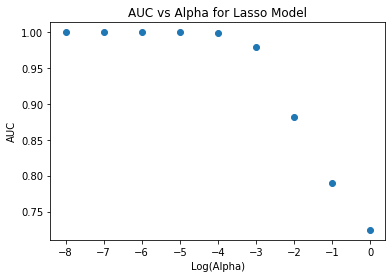

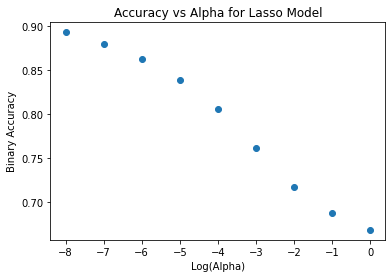

Best model is at alpha = -7 with AUC = 0.9997274327380904 and Accuracy = 0.8795976281166077


In [12]:
# model for drug descriptors
find_optimal_lasso(train_drugs, train_labels, 9)

Testing Alpha = 1
	FOLD: 1
		AUC = 0.5	Accuracy = 0.500214695930481
	FOLD: 2
		AUC = 0.5	Accuracy = 0.500214695930481
	FOLD: 3
		AUC = 0.5	Accuracy = 0.500178873538971
	FOLD: 4
		AUC = 0.5	Accuracy = 0.5001609921455383
	FOLD: 5
		AUC = 0.5	Accuracy = 0.5001502633094788
	Average metrics:	AUC = 0.5	Accuracy = 0.50018390417099
Testing Alpha = 0.1
	FOLD: 1
		AUC = 0.5836709843222276	Accuracy = 0.5122191309928894
	FOLD: 2
		AUC = 0.5767462354173118	Accuracy = 0.5197049379348755
	FOLD: 3
		AUC = 0.582720357689317	Accuracy = 0.5253613591194153
	FOLD: 4
		AUC = 0.5708849571885342	Accuracy = 0.5290688276290894
	FOLD: 5
		AUC = 0.5797505566302072	Accuracy = 0.5331084728240967
	Average metrics:	AUC = 0.5787546182495197	Accuracy = 0.5238925457000733
Testing Alpha = 0.01
	FOLD: 1
		AUC = 0.5834626602067755	Accuracy = 0.5357194542884827
	FOLD: 2
		AUC = 0.5889467464566465	Accuracy = 0.53766268491745
	FOLD: 3
		AUC = 0.5916912705333469	Accuracy = 0.5404889583587646
	FOLD: 4
		AUC = 0.5789994378366894

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 120.89610544995821, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5913201665118063	Accuracy = 0.5449481010437012
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 352.87563021473125, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5908593646298836	Accuracy = 0.5459284782409668
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 140.8436995130769, tolerance: 0.46574995169082034
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5853310603344355	Accuracy = 0.5470332503318787
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 94.11899252177682, tolerance: 0.46574995169082034
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5956049268228625	Accuracy = 0.5484286546707153
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 298.13590246513786, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5856497670932321	Accuracy = 0.5492764711380005
	Average metrics:	AUC = 0.5897530570784439	Accuracy = 0.5471229910850525
Testing Alpha = 0.0001
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1299.6215481064555, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5689634861289323	Accuracy = 0.5497208833694458
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1438.4779435088312, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5578435873043965	Accuracy = 0.5495393872261047
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1326.0294838239538, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5742898446157002	Accuracy = 0.5500603318214417
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1210.39491590121, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5628524586898496	Accuracy = 0.55024254322052
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1625.6558404494135, tolerance: 0.46574995169082034
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5617526621605072	Accuracy = 0.5505218505859375
	Average metrics:	AUC = 0.5651404077798772	Accuracy = 0.5500169992446899
Testing Alpha = 1e-05
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1601.787868460608, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5604463482441779	Accuracy = 0.5507751107215881
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1532.7664830801898, tolerance: 0.4657249664501574
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5533097724289486	Accuracy = 0.5507392287254333
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1600.0609533795962, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5520120024080066	Accuracy = 0.5507868528366089
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1575.13408354472, tolerance: 0.46574995169082034
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5685673245895544	Accuracy = 0.5511125326156616
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1612.2135878374997, tolerance: 0.46574995169082034
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5511847112236421	Accuracy = 0.5510801076889038
	Average metrics:	AUC = 0.5571040317788659	Accuracy = 0.5508987665176391
Testing Alpha = 1e-06
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1619.890160425355, tolerance: 0.4657249664501574
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5700823525507721	Accuracy = 0.5514061450958252
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1611.4932753984217, tolerance: 0.4657249664501574
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5673596669763875	Accuracy = 0.5518324971199036
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1627.4353050074142, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5556894873985413	Accuracy = 0.5518332123756409
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1603.498830795789, tolerance: 0.46574995169082034
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.557635203227201	Accuracy = 0.5520550012588501
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1593.6466068465245, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5466684999682768	Accuracy = 0.5519266724586487
	Average metrics:	AUC = 0.5594870420242357	Accuracy = 0.5518107056617737
Testing Alpha = 1e-07
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1641.709906624987, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5606980885801514	Accuracy = 0.5521719455718994
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1633.0118493842263, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5527615850331107	Accuracy = 0.5520963668823242
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1629.1777464038353, tolerance: 0.46574995169082034
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5514806400398974	Accuracy = 0.5519996881484985
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1646.5269948779462, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5673569582095762	Accuracy = 0.552210807800293
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1634.3540918139886, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5590454068601629	Accuracy = 0.5524488687515259
	Average metrics:	AUC = 0.5582685357445797	Accuracy = 0.5521855354309082
Testing Alpha = 1e-08
	FOLD: 1


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1641.6068836376821, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5590053168738847	Accuracy = 0.5525153279304504
	FOLD: 2


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1647.3401158400995, tolerance: 0.4657249664501575
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5697541038007168	Accuracy = 0.5527984499931335
	FOLD: 3


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1634.8489070426724, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5490511465328098	Accuracy = 0.5527216196060181
	FOLD: 4


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1644.8580098973366, tolerance: 0.46574995169082034
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.565305006794651	Accuracy = 0.5529411435127258
	FOLD: 5


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:513: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1632.7361538843604, tolerance: 0.4657499516908204
  model = cd_fast.sparse_enet_coordinate_descent(


		AUC = 0.5591052565958281	Accuracy = 0.5530077219009399
	Average metrics:	AUC = 0.560444166119578	Accuracy = 0.5527968525886535


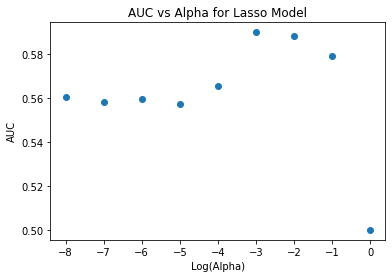

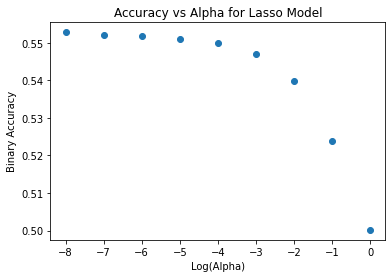

NameError: name 'test_auc' is not defined

In [120]:
# model for protein descriptors
find_optimal_lasso(train_prot, train_labels, 9, drug=False)

## Feature Selection with Lasso
**Drugs:** Using the point on the AUC graph where the plot began to plateau (alpha=1e-4). Training this model on all of the test data and removing features that have a coefficient of 0.

**Proteins:** Using the highest point on the AUC graph (alpha=1e-3). Training this model on all of the test data and removing features that have a coefficient of 0.

In [37]:
from sklearn.feature_selection import SelectFromModel

### Drugs

In [61]:
# preprocessing data
scaler = StandardScaler(with_std=False)
var = VarianceThreshold(0.01)
train_feat = scaler.fit_transform(train_drugs)
test_feat = scaler.transform(test_drugs)
train_feat = var.fit_transform(train_feat)
test_feat = var.transform(test_feat)

In [12]:
# threshold defaults to 1e-5 for Lasso models
lasso_feature_selector = SelectFromModel(estimator=Lasso(alpha=1e-4))

In [13]:
lasso_feature_selector.fit(train_feat, train_labels)

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2347.3023885755592, tolerance: 0.5821749130416095
  model = cd_fast.enet_coordinate_descent(


SelectFromModel(estimator=Lasso(alpha=0.0001))

In [69]:
len(np.where(np.abs(lasso_feature_selector.estimator_.coef_) >= 1e-3)[0])

1820

 Using a threshold of 1e-3 so the number of selected drug features is closer to the number of selected protein features.

In [70]:
lasso_feature_selector.set_params(**{'threshold':1e-3})

SelectFromModel(estimator=Lasso(alpha=0.0001), threshold=0.001)

In [71]:
# selecting top features from Lasso model
reduced_train_drugs = lasso_feature_selector.transform(train_feat)
reduced_test_drugs = lasso_feature_selector.transform(test_feat)

### Proteins

In [34]:
train_dataset.shape

(23287, 11471)

In [35]:
# preprocessing data

prot_var = VarianceThreshold(0.01)

# protein sequence vectorization
acc_vect = CountVectorizer(analyzer='char', ngram_range=(1,1))
train_acc = acc_vect.fit_transform(train_prot['sequence'])
test_acc = acc_vect.transform(test_prot['sequence'])
dc_vect = CountVectorizer(analyzer='char', ngram_range=(2,2))
train_dc = dc_vect.fit_transform(train_prot['sequence'])
test_dc = dc_vect.transform(test_prot['sequence'])
tc_vect = CountVectorizer(analyzer='char', ngram_range=(3,3))
train_tc = tc_vect.fit_transform(train_prot['sequence'])
test_tc = tc_vect.transform(test_prot['sequence'])

## the vectorizers return scipy sparse matrices so hstack is used to concat them
train_vect_feat = sparse.hstack([train_acc, train_dc, train_tc])
test_vect_feat = sparse.hstack([test_acc, test_dc, test_tc])

# removing vectorized features that have variance less than 0.01
train_vect_feat = prot_var.fit_transform(train_vect_feat)
test_vect_feat = prot_var.transform(test_vect_feat)

# dropping the column containing the sequence string because it isn't needed
prot_train_feat = train_prot.drop(columns=['sequence'])
prot_test_feat = test_prot.drop(columns=['sequence'])
## VarianceThreshold returns a scipy sparse matrix (if it is given one) so using hstack to combine them
# combining domain features with sequence vectorized features
prot_train_feat = sparse.hstack([train_vect_feat, sparse.coo_matrix(prot_train_feat)])
prot_test_feat = sparse.hstack([test_vect_feat, sparse.coo_matrix(prot_test_feat)])

In [38]:
# threshold is set to 1e-5 by default
lasso_prot_feat_selector = SelectFromModel(estimator=Lasso(alpha=1e-3, max_iter=3000))

In [42]:
lasso_prot_feat_selector.fit(prot_train_feat, train_labels)

SelectFromModel(estimator=Lasso(alpha=0.001, max_iter=3000))

In [56]:
len(np.where(np.abs(lasso_prot_feat_selector.estimator_.coef_) >= 1e-20)[0])

1228

In [57]:
# removing all features that had a coefficient of 0 (setting the threshold extremely so so thi)
lasso_prot_feat_selector.set_params(**{'threshold':1e-20})

SelectFromModel(estimator=Lasso(alpha=0.001, max_iter=3000), threshold=1e-20)

In [60]:
reduced_train_prot = lasso_prot_feat_selector.transform(prot_train_feat).A
reduced_test_prot = lasso_prot_feat_selector.transform(prot_test_feat).A

## Combining Drug and Protein Data

In [72]:
train_data = np.concatenate([reduced_train_drugs, reduced_train_prot], axis=1)
test_data = np.concatenate([reduced_test_drugs, reduced_test_prot], axis=1)

train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)
train_data['label'] = train_labels
test_data['label'] = test_labels

# Saving Data

In [14]:
scaler = load("models/drug_scaler.joblib")
var = load("models/drug_var.joblib")
prot_var = load("models/prot_var.joblib")
acc_vect = load("models/acc_vectorizer.joblib")
dc_vect = load("models/dc_vectorizer.joblib")
tc_vect = load("models/tc_vectorizer.joblib")
lasso_feature_selector = load("models/drug_lasso_feature_selector.joblib")
lasso_prot_feat_selector = load("models/prot_lasso_feature_selector.joblib")

In [75]:
# writing data to csv
train_data.to_csv("drug_target_data/datasets/reduced_train_dataset.csv", index=False)
test_data.to_csv("drug_target_data/datasets/reduced_test_dataset.csv", index=False)

# saving the models for future use
dump(scaler, "models/drug_scaler.joblib")
dump(var, "models/drug_var.joblib")
dump(prot_var, "models/prot_var.joblib")
dump(acc_vect, "models/acc_vectorizer.joblib")
dump(dc_vect, "models/dc_vectorizer.joblib")
dump(tc_vect, "models/tc_vectorizer.joblib")
dump(lasso_feature_selector, "models/drug_lasso_feature_selector.joblib")
dump(lasso_prot_feat_selector, "models/prot_lasso_feature_selector.joblib")

['models/prot_lasso_feature_selector.joblib']